In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import validation_curve
from sklearn.metrics import roc_auc_score
import os

In [5]:
normal_file_path = '/Users/shreyamantripragada/Documents/rise2021/data/normal'
schizophrenia_file_path = '/Users/shreyamantripragada/Documents/rise2021/data/schizophrenia'

In [24]:
def reshape_data (file_path): 
    '''
        Given the file_path of the folder, loop through the files within the folder and 
        return a combined dataframe consisting of EEG amplitudes for each patient within a single row.
        
        @param      file_path 
        
    '''
    new_df = pd.DataFrame() # create a new, empty data frame
    filenames = [] # create an empty list which will eventually contain the file names
    
    for filename in os.listdir(file_path): # loop through the files within the folder 
        new_df = new_df.append(pd.read_csv(os.path.join(file_path, filename)).transpose()) # append the values of each file into the data frame
        filenames.append(os.path.splitext(filename)[0]) # append the file names to the list 'filenames'
        
    first_row_values = new_df.index # get the row names and the 
    new_df.insert(loc = 0, column = '0', value = first_row_values) # push the current row indices to the first column
    new_df = new_df.T.reset_index(drop=True).T # reset the column indices
    new_df.index = filenames # reassign the new row indices to the filenames
    
    return new_df, filenames # return the new, combined data frame & filenames

In [26]:
normal_data, norm_filenames = reshape_data(normal_file_path)
schizo_data, schizo_filenames = reshape_data(schizophrenia_file_path)

In [120]:
normal_data['diagnosis'] = 0
schizo_data['diagnosis'] = 1
combined = normal_data
combined = combined.append(schizo_data)
FINAL_data = combined.sample(frac = 1)
FINAL_data

,0,1,2,3,4,5,6,7,8,9,...,122871,122872,122873,122874,122875,122876,122877,122878,122879,diagnosis
s43w1,409.33,389.94,629.08,728.18,769.11,788.5,667.86,489.04,168.04,129.26,...,-922.07,-1411.11,-1680.41,-1740.73,-1281.85,-51.7,308.08,829.43,939.31,0
S47W1,209.28,327.87,669.7,748.76,609.24,509.25,509.25,527.86,448.79,427.87,...,-941.77,-830.15,-641.8,-202.31,-111.62,-81.39,-11.63,209.28,58.13,0
088w1,-113.29,-75.53,-75.53,-90.63,385.18,347.42,362.52,385.18,445.6,445.6,...,-800.57,-823.22,-793.01,-483.36,-256.79,-22.66,-22.66,-196.37,-226.58,1
S174W1,549.10,588.91,469.48,329.46,28.83,-50.79,-230.62,-251.21,-230.62,-190.81,...,-431.04,-130.41,28.83,518.9,728.93,838.74,768.73,439.28,289.65,0
S084-1W,-91.23,-70.96,-30.41,8.11,129.75,148.0,8.11,-170.3,-391.28,-551.44,...,18.25,119.61,239.23,368.98,399.39,429.8,539.28,739.99,798.78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
S164W1,9.48,109.94,308.96,348.76,269.15,208.5,149.74,189.55,288.11,269.15,...,159.22,79.61,39.8,-70.13,-170.59,-411.31,-530.73,-610.34,-570.53,0
S169W,269.66,229.8,148.9,128.97,109.04,109.04,49.24,9.38,-30.48,-50.42,...,488.91,589.74,638.98,549.88,429.12,309.53,379.87,529.95,609.67,0
r229w1,909.79,808.88,749.24,669.73,529.06,409.79,449.55,548.94,629.98,608.57,...,-671.26,-451.07,-290.52,-110.09,59.63,198.78,139.15,-50.46,-330.28,1
382w1,349.76,329.87,149.12,169.91,569.37,729.34,709.45,609.14,569.37,609.14,...,69.59,-210.58,-250.34,-170.81,-90.38,159.97,239.5,-30.73,-310.89,1


In [8]:
def reduced_data(data):
    '''
        Given the data, iterate through each row, take the absolute value of the EEG amplitudes, 
        and take the average of all the amplitudes for each brain region. For each brain region, append
        the average values into a list and append that list to the 'final_summed_values.'
        
        @param       data     
    '''
    temp_sum = 0
    temp_avg = 0
    values_to_stop = [7679, 15359, 23039, 30719, 38399, 46079, 53759, 61439, 69119, 76799, 84479, 92159, 99839, 107519, 115199, 122879]
    summed_values = []
    final_summed_values = []

    for rows in data.index:
        row_data = [abs(float(x)) for x in data.loc[rows]]
        for index, value in enumerate(row_data):
            if index in values_to_stop:
                temp_avg = temp_sum/7680
                summed_values.append(temp_avg)
                temp_sum = 0
                temp_avg = 0
            else:
                temp_sum += value
        
        final_summed_values.append(summed_values)
        summed_values = []
        
    return final_summed_values

In [105]:
def plot_roc_auc_curve(false_positive_rate, true_positive_rate):  
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree')
    plt.plot(false_positive_rate, true_positive_rate)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    return plt

In [9]:
norm_averaged_values = reduced_data(normal_data)
schizo_averaged_values = reduced_data(schizo_data)

In [44]:
reduced_normal_data = pd.DataFrame(norm_averaged_values, columns = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', '01', '02'])
reduced_normal_data['diagnosis'] = 0
reduced_normal_data.index = norm_filenames
reduced_normal_data

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,01,02,diagnosis
S42W1,234.691796,288.619884,297.082391,201.988486,201.117730,308.864366,320.471932,314.160993,196.207816,212.271569,386.414909,366.827124,331.260919,210.572525,316.188987,368.760953,0
S31W,209.802646,310.155904,323.160348,227.777398,275.764142,304.740733,310.459188,285.944573,255.524574,419.788974,457.526612,517.576155,517.303068,475.087018,422.721320,486.114878,0
S167W1,352.218137,434.144626,355.861077,446.941460,369.187810,351.056225,401.587008,343.221223,281.817039,303.818939,392.647286,431.740410,393.273398,387.944044,542.842977,536.968509,0
S50W,269.647852,338.634255,344.864874,234.133116,256.133755,368.086639,368.735112,355.779238,234.084414,258.421585,391.401720,409.314609,358.623829,293.393776,625.496439,629.259563,0
S165W1,205.958906,257.508954,265.755559,242.377389,203.218307,274.589074,278.940344,279.626380,257.992473,213.305772,249.756887,298.145780,280.551883,300.361348,294.697612,314.157604,0
s158w1,210.156392,243.122535,242.398858,236.778044,206.025147,252.486010,265.404565,246.924285,232.915249,209.578012,267.934919,294.790904,314.715503,271.258555,327.399674,450.594164,0
s178w1,233.345544,262.343376,276.535676,240.188206,236.186406,256.556363,262.057082,270.026048,233.934716,231.208828,275.671909,274.158747,293.347750,225.355462,362.525708,455.596702,0
S18W1,183.823220,208.668583,246.833941,204.128240,142.202448,237.652893,316.793198,238.867346,200.856008,168.485749,292.000155,320.969673,275.168212,201.090997,412.535669,398.371788,0
s27w1,287.675622,325.139793,283.005382,240.012783,245.015546,307.517049,321.980163,294.850973,175.702001,285.849380,412.084990,477.351270,397.399457,239.099220,578.065659,598.894160,0
S163W1,207.762145,260.002005,256.324676,197.574137,248.676862,276.740984,286.515740,267.751495,196.478302,284.604995,321.380874,320.558260,332.958268,206.182699,413.562566,343.096845,0


In [45]:
reduced_schizo_data = pd.DataFrame(schizo_averaged_values, columns = ['F7', 'F3', 'F4', 'F8', 'T3', 'C3', 'Cz', 'C4', 'T4', 'T5', 'P3', 'Pz', 'P4', 'T6', '01', '02'])
reduced_schizo_data['diagnosis'] = 1
reduced_schizo_data.index = schizo_filenames
reduced_schizo_data

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,01,02,diagnosis
312w1,206.320397,281.263372,299.172999,257.392182,211.820132,294.820716,319.786544,345.369290,272.147546,276.660156,449.150581,524.197324,523.097816,435.508664,603.983848,633.859315,1
642w1,366.396224,382.963122,418.888553,297.033108,282.734802,330.218452,328.949447,336.694488,316.450935,238.148698,247.791669,248.684117,263.109678,262.007634,296.003741,254.928184,1
387-02w1,234.795372,287.451087,178.627186,193.460809,207.708783,281.326902,286.289586,265.439389,262.181173,202.033771,284.241773,292.374388,285.597331,281.038923,293.338473,280.024243,1
s351w,235.326818,276.417191,303.862620,242.048113,224.213878,278.223172,293.151385,310.499721,301.374194,240.573027,288.047160,288.309579,360.355677,326.735962,309.567799,414.304186,1
423w,271.413565,319.346132,293.445698,245.076982,251.858844,240.822275,274.157577,264.048354,225.329668,226.555383,242.301031,260.228691,260.978638,231.488794,285.456193,283.472827,1
485w1,321.123027,366.058307,315.590077,230.039855,273.682033,379.195359,392.642043,379.276591,237.137714,218.613786,365.679971,490.870199,497.869384,373.756691,468.536046,523.482060,1
314w1,188.503118,206.377499,210.450124,157.257440,197.954727,250.850112,257.437574,244.540417,166.504868,236.484505,325.113289,350.156646,336.925900,232.581078,432.306539,371.034786,1
585w1,256.471844,187.546342,229.976701,251.165103,284.208555,328.489284,306.831605,330.613654,282.786000,281.657758,285.789540,337.777720,296.233518,261.141142,425.521574,420.625659,1
113w1,311.777090,282.284711,243.702085,209.386413,230.519184,202.143195,215.298730,266.146725,219.864124,197.267254,204.431280,225.165079,291.204492,237.693068,257.713474,343.016491,1
156w1,173.870042,221.301829,201.075190,151.966254,195.879945,270.835018,283.097083,276.803309,190.147621,179.189104,360.347039,419.801158,408.060797,261.521094,469.821441,514.013210,1


In [63]:
combined_data = reduced_normal_data
combined_data = combined_data.append(reduced_schizo_data)
final_data = combined_data.sample(frac = 1)
final_data

,F7,F3,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,01,02,diagnosis
32w1,173.479447,226.826589,234.218458,230.691579,170.289599,229.840647,287.880493,259.756068,213.937382,164.451257,261.906745,296.724189,299.378267,247.626910,335.810254,380.445263,1
088w1,269.305384,332.407086,350.191853,301.477253,265.554741,286.413564,294.396764,314.602624,317.583328,290.625426,347.461970,388.176574,326.486996,290.390508,307.706076,288.323259,1
221w,419.996215,434.509292,403.317749,381.659124,401.405223,289.698764,265.922202,252.380602,352.466681,402.338480,332.502305,321.518884,299.118344,517.946504,551.889538,538.393368,1
585w1,256.471844,187.546342,229.976701,251.165103,284.208555,328.489284,306.831605,330.613654,282.786000,281.657758,285.789540,337.777720,296.233518,261.141142,425.521574,420.625659,1
s20w1,147.782771,270.373665,248.174302,164.866094,162.434517,226.305784,251.915995,216.597297,114.373884,164.988147,267.253741,337.189439,231.344311,157.555822,311.801208,331.440301,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575w1,170.152150,279.777065,242.932027,173.217540,155.108012,218.686546,232.657583,220.663540,173.691340,166.997212,221.092523,252.668540,207.340418,161.949553,276.865313,280.286714,1
S85W1,272.113160,295.200184,319.971753,249.162530,235.202449,303.822458,324.956053,319.940781,243.296194,229.908083,363.847227,329.659947,329.868052,258.558396,566.683276,503.317306,0
s12w1,180.226103,207.499172,212.721874,189.212034,162.129931,219.814723,234.199620,238.083526,138.567995,135.117633,223.455811,226.202848,226.772352,175.112195,229.534030,235.926233,0
S165W1,205.958906,257.508954,265.755559,242.377389,203.218307,274.589074,278.940344,279.626380,257.992473,213.305772,249.756887,298.145780,280.551883,300.361348,294.697612,314.157604,0


In [121]:
X = FINAL_data.values
Y = FINAL_data['diagnosis']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

In [122]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

                                                                      fpr  \
classifiers                                                                 
LogisticRegression                                   [0.0, 0.0, 0.0, 1.0]   
GaussianNB                                                [0.0, 0.0, 1.0]   
KNeighborsClassifier    [0.0, 0.0, 0.0, 0.3333333333333333, 0.58333333...   
DecisionTreeClassifier                                    [0.0, 0.0, 1.0]   
RandomForestClassifier  [0.0, 0.0, 0.0, 0.0, 0.0, 0.3333333333333333, ...   

                                                                      tpr  auc  
classifiers                                                                     
LogisticRegression                    [0.0, 0.1111111111111111, 1.0, 1.0]  1.0  
GaussianNB                                                [0.0, 1.0, 1.0]  1.0  
KNeighborsClassifier        [0.0, 0.5555555555555556, 1.0, 1.0, 1.0, 1.0]  1.0  
DecisionTreeClassifier                                 

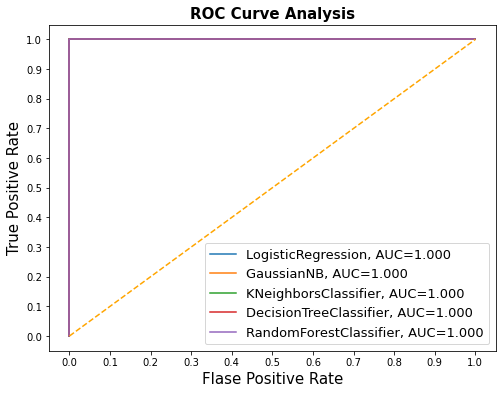

In [103]:
## IGNORE THIS!!!

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

classifiers = [LogisticRegression(random_state=1234), GaussianNB(), KNeighborsClassifier(), DecisionTreeClassifier(random_state=1234),
               RandomForestClassifier(random_state=1234)]

result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

for cls in classifiers:
    model = cls.fit(X_train, Y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(Y_test,  yproba)
    auc = roc_auc_score(Y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__, 'fpr':fpr, 'tpr':tpr,'auc':auc}, ignore_index=True)

result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

print (result_table)

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

    

roc_auc_score 0.5625


<module 'matplotlib.pyplot' from '/Users/shreyamantripragada/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

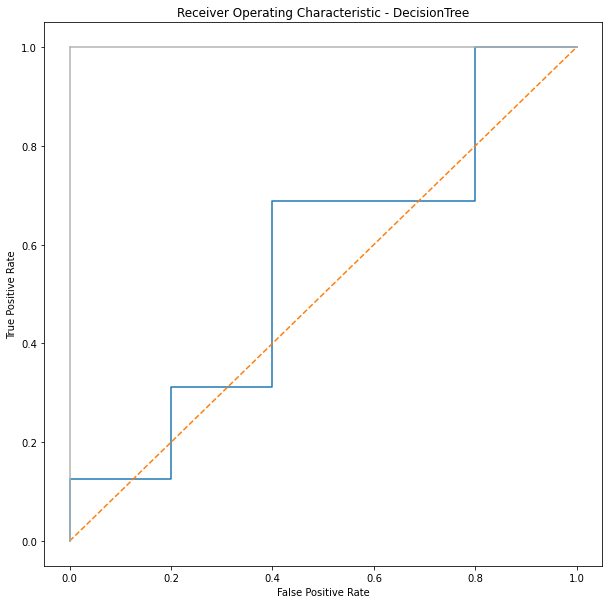

In [123]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0) #look into parameters
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test, y_score)

print('roc_auc_score', roc_auc_score(Y_test, y_score))

plot_roc_auc_curve(false_positive_rate, true_positive_rate)

#print('Logistic Regression', roc_auc_score(Y_test, classifier.predict(X_test)))

In [126]:
from sklearn.linear_model import LinearRegression
classifier = LinearRegression() #look into parameters
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test, y_score)

print('roc_auc_score', roc_auc_score(Y_test, y_score))

plot_roc_auc_curve(false_positive_rate, true_positive_rate)

AttributeError: 'LinearRegression' object has no attribute 'predict_proba'

roc_auc_score 0.65


<module 'matplotlib.pyplot' from '/Users/shreyamantripragada/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

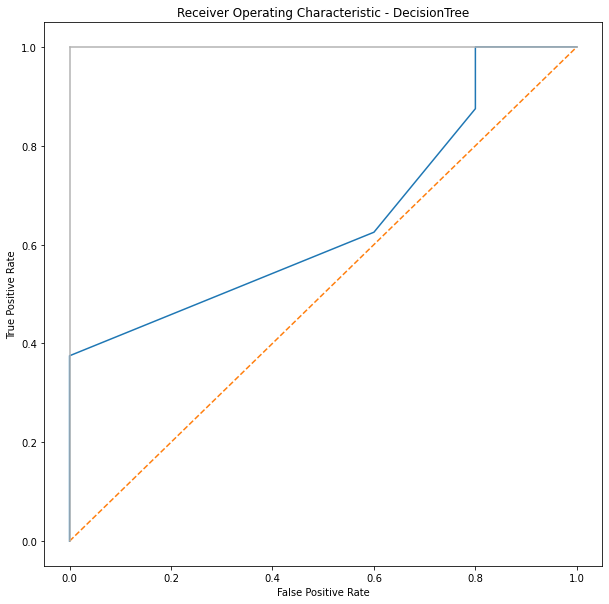

In [124]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)
y_score = classifier.predict_proba(X_test)[:,1]
false_positive_rate, true_positive_rate, threshold = roc_curve(Y_test, y_score)

print('roc_auc_score', roc_auc_score(Y_test, y_score))

plot_roc_auc_curve(false_positive_rate, true_positive_rate)



In [93]:
#Using Logistic Regression Algorithm to the Training Set
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, Y_train)
print('Logistic Regression', roc_auc_score(Y_test, classifier.predict(X_test)))


#Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, Y_train)

#Using SVC method of svm class to use Support Vector Machine Algorithm
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train, Y_train)

#Using SVC method of svm class to use Kernel SVM Algorithm
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, Y_train)

#Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, Y_train)

#Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm

from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)

#Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm

from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, Y_train)

1.0


"\n#Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm\nfrom sklearn.neighbors import KNeighborsClassifier\nclassifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)\nclassifier.fit(X_train, Y_train)\n\n#Using SVC method of svm class to use Support Vector Machine Algorithm\nfrom sklearn.svm import SVC\nclassifier = SVC(kernel = 'linear', random_state = 0)\nclassifier.fit(X_train, Y_train)\n\n#Using SVC method of svm class to use Kernel SVM Algorithm\nfrom sklearn.svm import SVC\nclassifier = SVC(kernel = 'rbf', random_state = 0)\nclassifier.fit(X_train, Y_train)\n\n#Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm\nfrom sklearn.naive_bayes import GaussianNB\nclassifier = GaussianNB()\nclassifier.fit(X_train, Y_train)\n\n#Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm\n\nfrom sklearn.tree import DecisionTreeClassifier\nclassifier = DecisionTreeClassifier(criterion = 'entropy', r